In [14]:
#import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

#### Datos de Yelp metricas temporales 
 Métricas Temporales 
Estas métricas se analizan a lo largo del tiempo y se usan para observar:

Tendencias (crecimiento o decrecimiento)

Estacionalidades (cambios cíclicos)

Patrones repetitivos

Anomalías o picos inesperados

#### Análisis exploratorio de los datos de Google Maps de pizzerías

</br>

El control de la calidad de los datos de los archivos de Yelp se hizo en las notebooks llamadas Yelp Business y Yelp Business Reviews. </br>
A continuación se detallarán brevemente los hallazgos. </br>

In [15]:
# Leo los archivos con datos de Yelp
Yelp_pizza = pd.read_parquet('Yelp\\business.parquet' , engine='fastparquet')
Yelp_pizza_rev = pd.read_parquet('Yelp\\business_pizza_rev.parquet' , engine='fastparquet')

#### Análisis exploratorio de los datos de Yelp de pizzerías

##### Analizaremos ahora los datos de reviews de Yelp

In [16]:
Yelp_pizza_rev['date'].agg(['min', 'max'])

min   2005-04-10 23:10:56
max   2022-01-19 19:03:21
Name: date, dtype: datetime64[ns]

In [17]:
#  Extraer el año de la columna 'date'
Yelp_pizza_rev['year'] = Yelp_pizza_rev['date'].dt.year

# Contar el número de reseñas por año
Yelp_reviews_per_year = Yelp_pizza_rev['year'].value_counts().sort_index()

In [18]:
pizzeria_stats = Yelp_pizza_rev.groupby('name').agg(
    num_reviews=('stars_by_user', 'count'),  # Count reviews
    avg_rating=('stars_by_user', 'mean')  # Average rating
).reset_index()

top_pizzeria_stats = pizzeria_stats.sort_values(by='num_reviews', ascending=False).head(10)

#### Relacion de datos 

#### cantidad de valoraciones a lo largo del tiempo agrupado por año y trimestre 

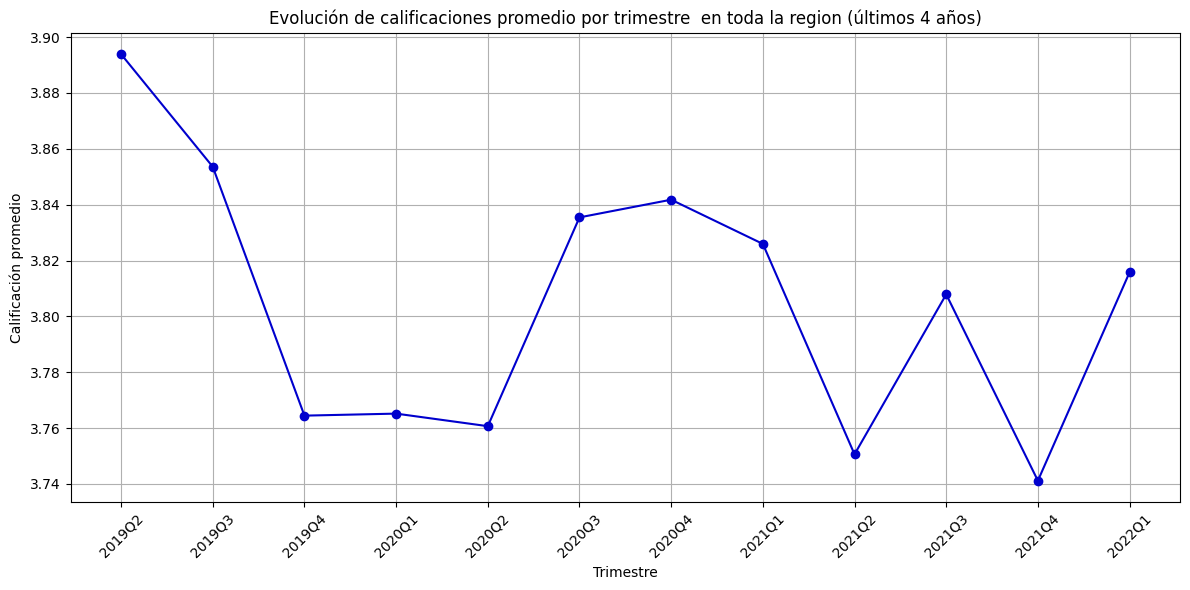

In [ ]:
# Paso 1: Filtrar últimos 4 años
hoy = pd.Timestamp.today()
cuatro_anos_atras = hoy - pd.DateOffset(years=6)# ultimas reseñas del 2022

# Asegurarse de que 'date' es datetime
Yelp_pizza_rev['date'] = pd.to_datetime(Yelp_pizza_rev['date'])

# Filtrar
df_filtrado = Yelp_pizza_rev[Yelp_pizza_rev['date'] >= cuatro_anos_atras].copy()

# Paso 2: Crear columna de trimestre (formato '2023Q1', etc.)
df_filtrado['trimestre'] = df_filtrado['date'].dt.to_period('Q').astype(str)

# Paso 3: Agrupar por trimestre y calcular promedio de calificaciones
calificaciones_trimestre = (
    df_filtrado
    .groupby('trimestre')['stars_by_user']
    .mean()
    .reset_index()
    .rename(columns={'stars_by_user': 'calificacion_promedio'})
)

# Paso 4: Graficar
plt.figure(figsize=(12, 6))
plt.plot(calificaciones_trimestre['trimestre'], calificaciones_trimestre['calificacion_promedio'], marker='o', color='mediumblue')
plt.xticks(rotation=45)
plt.xlabel("Trimestre")
plt.ylabel("Calificación promedio")
plt.title("Evolución de calificaciones promedio en las regiones de california y nevada por trimestre (últimos 4 años)")
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Análisis de Valoraciones Promedio
Las valoraciones promedio de las pizzerías en las regiones analizadas fluctúan entre 3.0 y 4.0 estrellas, con una media general cercana a 3.5. Este rango indica un nivel de satisfacción moderado por parte de los usuarios, pero también refleja una alta competencia en el sector.

Para destacarse en este rubro y mejorar su posicionamiento dentro de las plataformas de reseñas como Yelp y Google Maps, se recomienda que los establecimientos apunten a superar consistentemente una valoración promedio de 3.7 o más. Alcanzar este umbral no solo mejora la percepción de calidad frente a los clientes, sino que también favorece la visibilidad en los rankings y algoritmos de recomendación.

In [20]:
join_key = "business_id"

# Columnas duplicadas (excepto la clave de unión)
cols_to_exclude = [col for col in Yelp_pizza.columns if col in Yelp_pizza_rev.columns and col != join_key]

# Eliminar columnas duplicadas del segundo DataFrame antes de hacer el merge
Yelp_pizza_cleaned = Yelp_pizza.drop(columns=cols_to_exclude)

# Merge sin columnas repetidas
df_full = Yelp_pizza_rev.merge(Yelp_pizza_cleaned, on=join_key, how="left")
Yelp_pizza_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41946 entries, 0 to 41945
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   address         41946 non-null  object        
 1   business_id     41946 non-null  object        
 2   city            41946 non-null  object        
 3   latitude        41946 non-null  float64       
 4   longitude       41946 non-null  float64       
 5   name            41946 non-null  object        
 6   postal_code     41946 non-null  object        
 7   review_count    41946 non-null  int64         
 8   stars_business  41946 non-null  float64       
 9   state           41946 non-null  object        
 10  review_id       41946 non-null  object        
 11  user_id         41946 non-null  object        
 12  stars_by_user   41946 non-null  int64         
 13  useful          41946 non-null  int64         
 14  funny           41946 non-null  int64         
 15  co

#### Las ciudades  con el  peor promedio de calificaciones de los usuarios 

In [21]:

df_ful_ultimos_6 = df_full[df_full['date'] >= pd.Timestamp.today() - pd.DateOffset(years=5)]
# Agrupar por ciudad y contar la cantidad de reseñas (filas)
ciudad_reviews = df_full.groupby('city').size().reset_index(name='cantidad_reviews')

# Filtrar ciudades con más de 5000 reseñas
ciudad_reviews_500 = ciudad_reviews[ciudad_reviews['cantidad_reviews'] > 100]

# Ordenar de mayor a menor
ciudad_reviews_500 = ciudad_reviews_500.sort_values(by='cantidad_reviews', ascending=False)

# Mostrar las 10 ciudades con más reseñas
print(ciudad_reviews_500.tail(20))

# Filtrar df_full por las ciudades seleccionadas
df_filtrado = df_full[df_full["city"].isin(ciudad_reviews_500["city"])]

df_filtrado['date'] = pd.to_datetime(df_filtrado['date'], errors='coerce')


ultimo_anio = df_filtrado['date'].dt.year.max()

# Filtrar datos excluyendo el último año
df_sin_ultimo_anio = df_filtrado[df_filtrado['date'].dt.year < ultimo_anio]

                 city  cantidad_reviews
179    St. Petersburg               146
194        Warminster               145
12           Bensalem               141
28        Carpinteria               134
176     St Petersburg               132
109       Maple Shade               130
157     Schwenksville               130
130        Norristown               130
38       Collingswood               128
177         St. Louis               125
84            Holiday               120
119         Mt Juliet               119
146  Richmond Heights               117
31        Cherry Hill               115
8             Ballwin               114
27             Carmel               109
100      Land O Lakes               105
65             Folsom               104
133       Palm Harbor               104
105         Levittown               103


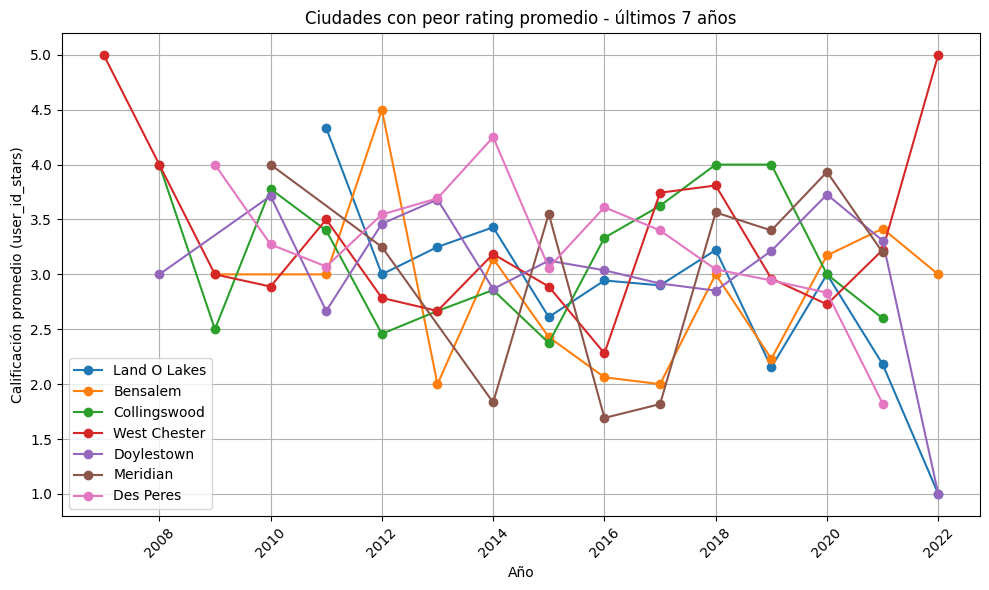

In [22]:
# Calcular ciudades con peor promedio en ese rango de tiempo
ciudades_peores = (
    df_filtrado.groupby('city')['stars_by_user']
    .mean()
    .nsmallest(7)
    .index
)

# Filtrar por las ciudades peores
df_peores = df_filtrado[df_filtrado['city'].isin(ciudades_peores)]

# Agrupar por ciudad y año
df_grouped = (
    df_peores.groupby(['city', 'year'])['stars_by_user']
    .mean()
    .reset_index()
    .rename(columns={'stars_by_user': 'calificacion_promedio'})
    .sort_values(by='year', ascending=True)
)
# Graficar
plt.figure(figsize=(10, 6))
for ciudad in ciudades_peores:
    data_ciudad = df_grouped[df_grouped['city'] == ciudad]
    plt.plot(data_ciudad['year'], data_ciudad['calificacion_promedio'], label=ciudad, marker='o')

plt.xticks(rotation=45)
plt.xlabel("Año")
plt.ylabel("Calificación promedio (user_id_stars)")
plt.title("Ciudades con peor rating promedio - últimos 7 años")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Estas son las ciudades en la cuales las pizzerias no cuentan con un buen promedio de reviews. Este hallazgo resulta relevante ya que sugiere la necesidad de revisar las estrategias operativas y de marketing en estas localidades. Mejorar la experiencia del cliente en estas zonas podría tener un impacto directo en el exito del futuro negocio.